In [1]:
import warnings
warnings.filterwarnings('ignore')

/Users/ashkan/Documents/projects.nosync/sandbox/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/Users/ashkan/Documents/projects.nosync/sandbox/lib/python3.12/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


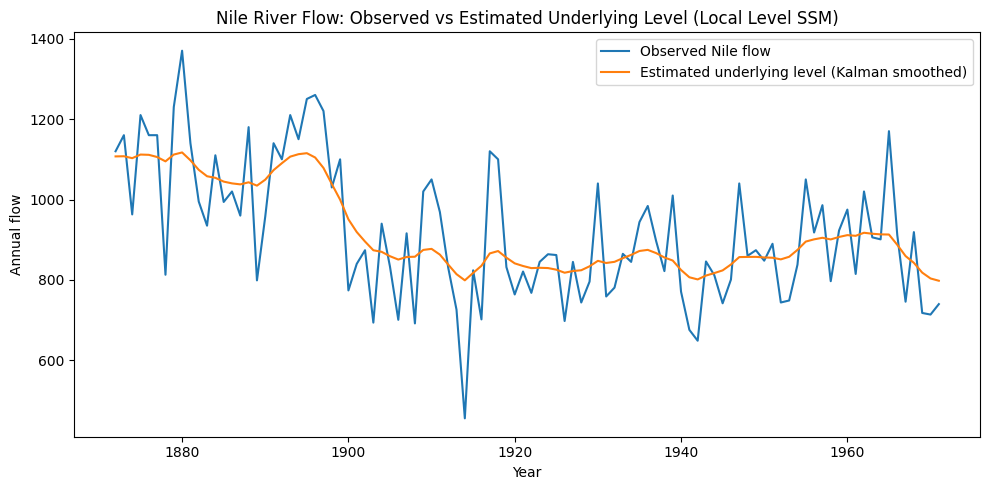

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Robust import path
try:
    from statsmodels.tsa.statespace.unobserved_components import UnobservedComponents
except ModuleNotFoundError:
    from statsmodels.tsa.statespace.structural import UnobservedComponents
# -----------------------------
# 1) Nile River: Local Level SSM
# -----------------------------
nile = sm.datasets.nile.load_pandas().data.copy()
# Build a proper annual time index
nile.index = pd.PeriodIndex(nile['year'].astype(int), freq='Y').to_timestamp(how='end')
y_nile = nile['volume'].astype(float)

# Local level model (random-walk level + observation noise)
mod_nile = UnobservedComponents(y_nile, level='local level')
res_nile = mod_nile.fit(disp=False)

# Smoothed level (underlying state estimate)
try:
    level_smoothed = res_nile.level['smoothed']  # available on recent statsmodels
except Exception:
    # Fallback: take first row of smoothed_state matrix
    level_smoothed = pd.Series(
        res_nile.filter_results.smoothed_state[0],
        index=y_nile.index,
        name="level_smoothed"
    )

# Plot: Observed vs Smoothed Level
plt.figure(figsize=(10, 5))
plt.plot(y_nile.index, y_nile.values, label="Observed Nile flow")
plt.plot(y_nile.index, level_smoothed, label="Estimated underlying level (Kalman smoothed)")
plt.title("Nile River Flow: Observed vs Estimated Underlying Level (Local Level SSM)")
plt.xlabel("Year")
plt.ylabel("Annual flow")
plt.legend()
plt.tight_layout()
# plt.savefig("nile_observed_vs_level.png", dpi=160)
plt.show()

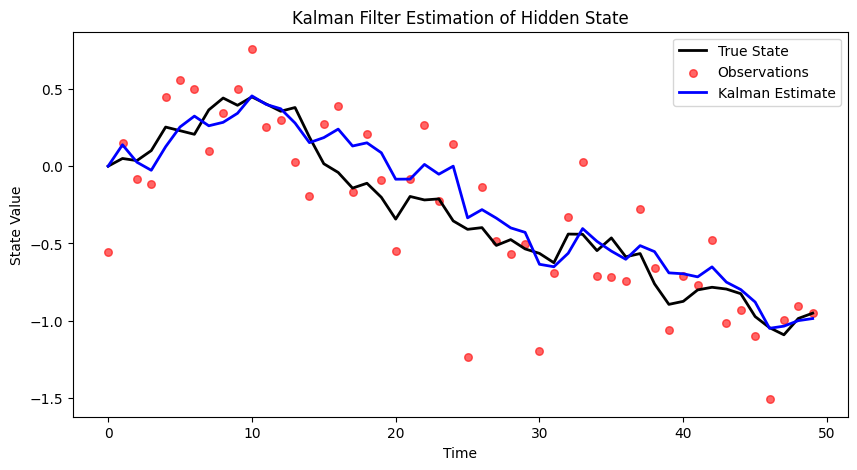

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Time steps
n = 50
A = 1      # state transition coefficient
C = 1      # observation coefficient
Q = 0.01   # process noise variance
R = 0.1    # observation noise variance

# True hidden state and observations
x_true = np.zeros(n)
y_obs = np.zeros(n)
x_true[0] = 0
for t in range(1, n):
    x_true[t] = A * x_true[t-1] + np.random.normal(0, np.sqrt(Q))
y_obs = C * x_true + np.random.normal(0, np.sqrt(R), n)

# Kalman filter initialization
x_pred = np.zeros(n)
P = np.zeros(n)
x_pred[0] = 0
P[0] = 1

# Kalman Filter recursion
for t in range(1, n):
    # Predict
    x_pred_prior = A * x_pred[t-1]
    P_prior = A * P[t-1] * A + Q
    
    # Update
    K = P_prior * C / (C * P_prior * C + R)
    x_pred[t] = x_pred_prior + K * (y_obs[t] - C * x_pred_prior)
    P[t] = (1 - K * C) * P_prior

# Plot
plt.figure(figsize=(10,5))
plt.plot(x_true, label='True State', color='k', linewidth=2)
plt.scatter(range(n), y_obs, label='Observations', color='r', s=30, alpha=0.6)
plt.plot(x_pred, label='Kalman Estimate', color='b', linewidth=2)
plt.legend()
plt.title("Kalman Filter Estimation of Hidden State")
plt.xlabel("Time")
plt.ylabel("State Value")
plt.show()


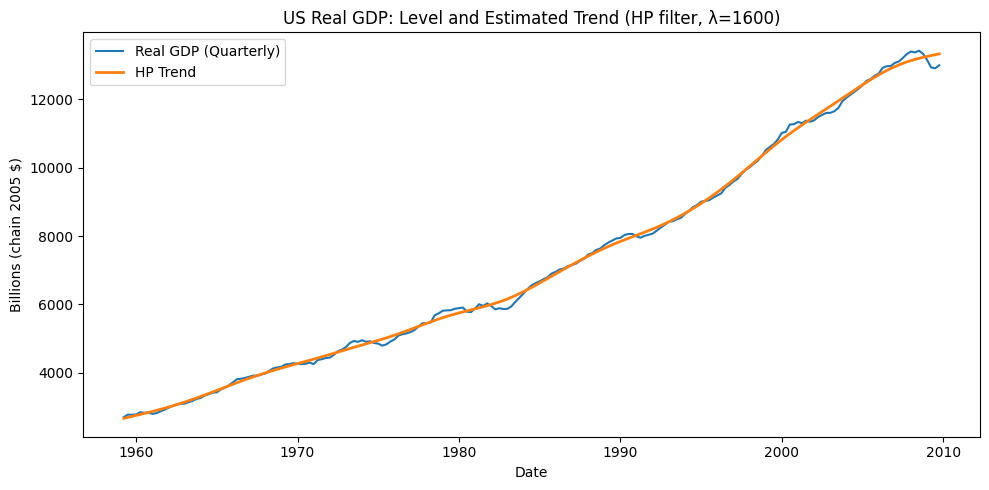

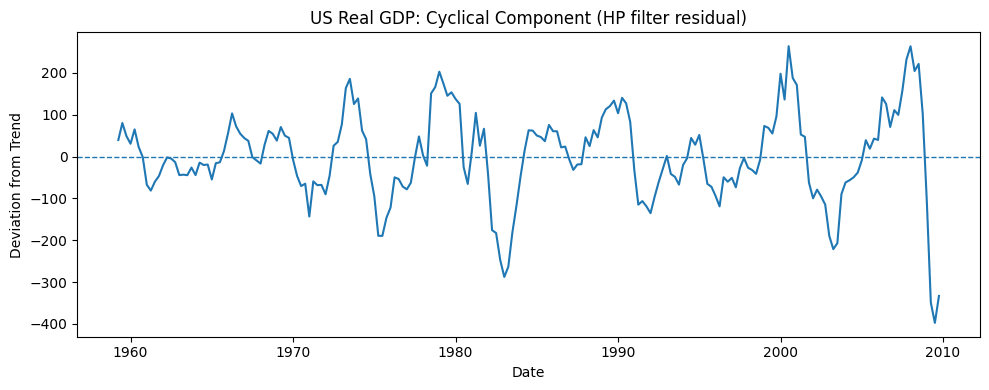

In [4]:
# Real GDP decomposition into trend and cycle using HP filter
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter

# 1) Load quarterly US macro data from statsmodels (1959Q1–2009Q3)
macro = sm.datasets.macrodata.load_pandas().data.copy()

# Build a proper quarterly index and select real GDP
macro['quarter'] = pd.PeriodIndex(
    year=macro['year'].astype(int),
    quarter=macro['quarter'].astype(int),
    freq='Q'
)
gdp = macro.set_index(macro['quarter'].astype(str))['realgdp'].astype(float)
gdp.index = pd.PeriodIndex(gdp.index, freq='Q').to_timestamp(how='end')

# 2) HP filter (λ=1600 for quarterly data)
cycle, trend = hpfilter(gdp, lamb=1600)

# 3) Plot: GDP level + trend
plt.figure(figsize=(10, 5))
plt.plot(gdp.index, gdp.values, label='Real GDP (Quarterly)')
plt.plot(trend.index, trend.values, label='HP Trend', linewidth=2)
plt.title('US Real GDP: Level and Estimated Trend (HP filter, λ=1600)')
plt.xlabel('Date')
plt.ylabel('Billions (chain 2005 $)')
plt.legend()
plt.tight_layout()
plt.show()

# 4) Plot: cyclical component (deviation from trend)
plt.figure(figsize=(10, 4))
plt.plot(cycle.index, cycle.values, label='Cyclical Component')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('US Real GDP: Cyclical Component (HP filter residual)')
plt.xlabel('Date')
plt.ylabel('Deviation from Trend')
plt.tight_layout()
plt.show()


/Users/ashkan/Documents/projects.nosync/sandbox/lib/python3.12/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


                            Unobserved Components Results                            
Dep. Variable:                             y   No. Observations:                  240
Model:                    local linear trend   Log Likelihood                -489.697
                   + stochastic seasonal(12)   AIC                            991.395
                          + stochastic cycle   BIC                           1011.891
Date:                       Sat, 25 Oct 2025   HQIC                           999.667
Time:                               10:07:45                                         
Sample:                           01-31-2000                                         
                                - 12-31-2019                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

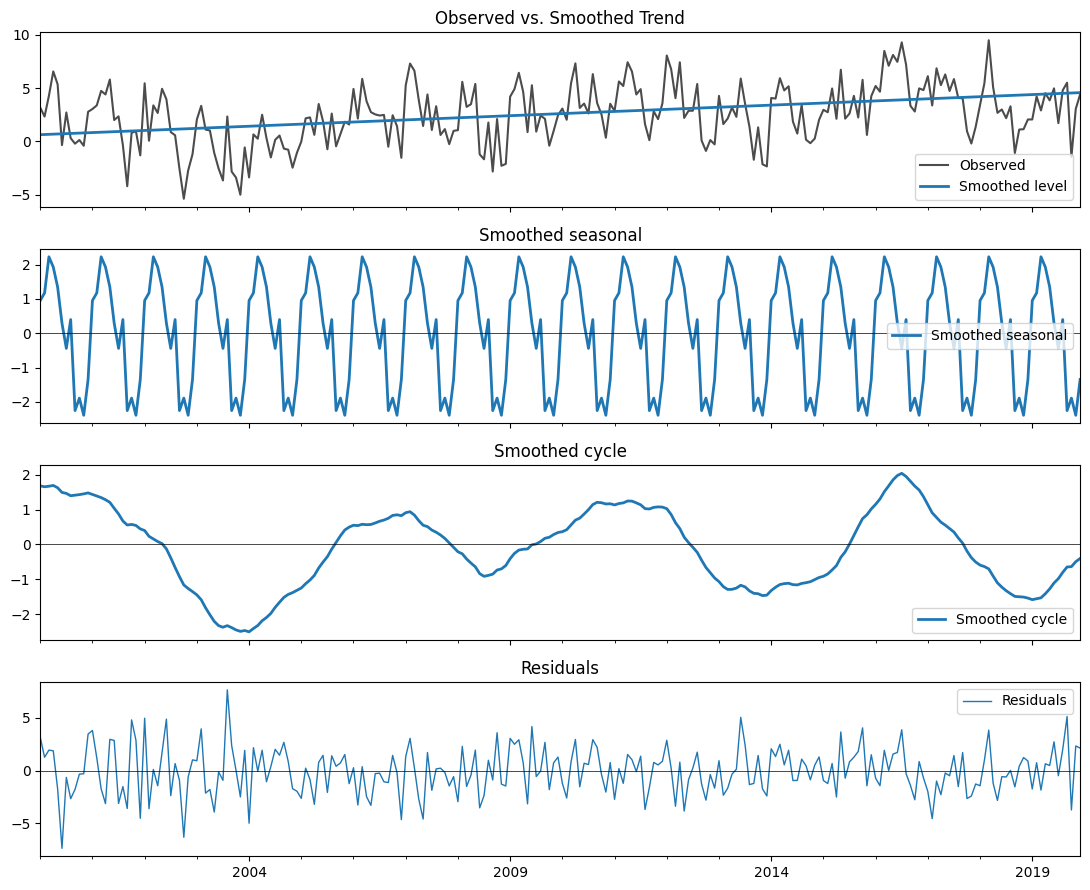

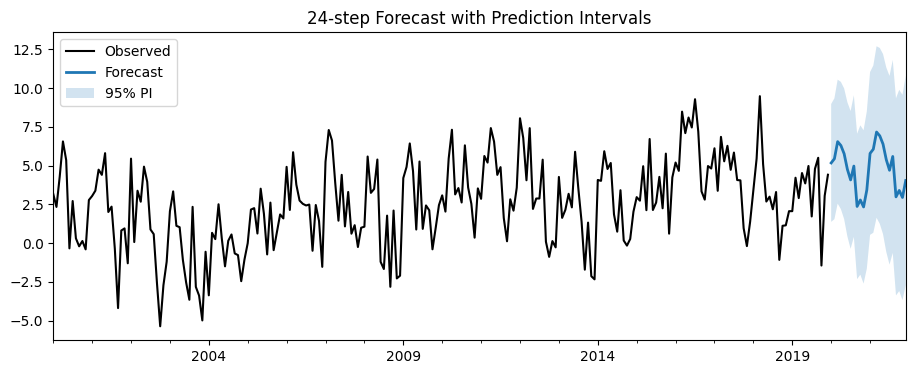

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Robust import path
try:
    from statsmodels.tsa.statespace.unobserved_components import UnobservedComponents
except ModuleNotFoundError:
    from statsmodels.tsa.statespace.structural import UnobservedComponents

# --- helper to normalize components to pandas.Series ---
def comp_series(res, attr, idx):
    """
    Return a pandas Series for a component 'attr', handling:
    - new statsmodels: attr is already a Series
    - older statsmodels: attr is a Bunch with .smoothed / ['smoothed']
    - very old: attr may be ndarray
    """
    if not hasattr(res, attr):
        return None
    comp = getattr(res, attr)

    # Bunch -> smoothed
    if hasattr(comp, "smoothed"):
        comp = comp.smoothed
    elif isinstance(comp, dict) and "smoothed" in comp:
        comp = comp["smoothed"]

    # If it's ndarray, wrap as Series
    if isinstance(comp, np.ndarray):
        comp = pd.Series(comp, index=idx)

    # If it's already a Series but without index, attach it
    if isinstance(comp, pd.Series) and comp.index.size != len(idx):
        comp = pd.Series(comp.values, index=idx)

    return comp

# ---- data: monthly series with trend + seasonal + cycle + noise ----
np.random.seed(0)
n = 240
t = np.arange(n)
trend_true = 0.02 * t 
season = 2*np.sin(2*np.pi*t/12) + 0.5*np.sin(2*np.pi*t/6) 
cycle = 1.5*np.sin(2*np.pi*t/60)

y = trend_true + season + cycle + np.random.normal(0, 1.8, n)
idx = pd.date_range('2000-01-31', periods=n, freq='ME')
y = pd.Series(y, index=idx)

# ---- model ----
mod = UnobservedComponents(
    y,
    level='local linear trend', # Level and slope both evolve stochastically. other options 'random walk with drift', 'deterministic trend','local level', 'fixed intercept'
    seasonal=12,
    cycle=True,
    stochastic_cycle=True,
)

# Use a valid optimizer name
res = mod.fit(method='powell', disp=False) # other options such as 'bfgs'
print(res.summary())

# ---- pull components safely ----
lev = comp_series(res, "level", idx)
sea = comp_series(res, "seasonal", idx)
cyc = comp_series(res, "cycle", idx)
resid = pd.Series(getattr(res, "resid", np.nan*np.zeros(len(y))), index=idx)

# ---- plot ----
fig, axes = plt.subplots(4, 1, figsize=(11, 9), sharex=True)

y.plot(ax=axes[0], color='black', alpha=0.7, label='Observed')
if lev is not None: lev.plot(ax=axes[0], lw=2, label='Smoothed level')
axes[0].legend(); axes[0].set_title('Observed vs. Smoothed Trend')

if sea is not None:
    sea.plot(ax=axes[1], lw=2, label='Smoothed seasonal')
    axes[1].axhline(0, color='k', lw=0.5)
    axes[1].legend(); axes[1].set_title('Smoothed seasonal')
else:
    axes[1].set_visible(False)

if cyc is not None:
    cyc.plot(ax=axes[2], lw=2, label='Smoothed cycle')
    axes[2].axhline(0, color='k', lw=0.5)
    axes[2].legend(); axes[2].set_title('Smoothed cycle')
else:
    axes[2].set_visible(False)

resid.plot(ax=axes[3], lw=1, label='Residuals')
axes[3].axhline(0, color='k', lw=0.5); axes[3].legend(); axes[3].set_title('Residuals')

plt.tight_layout(); plt.show()

# ---- forecast (handles old/new APIs) ----
steps = 24
try:
    fc = res.get_forecast(steps=steps)
    pred = fc.predicted_mean
    pi = fc.conf_int()
except AttributeError:
    pred = res.predict(start=len(y), end=len(y)+steps-1)
    # crude PI if not available
    resid_std = float(np.nanstd(resid, ddof=1))
    fut_idx = pd.date_range(y.index[-1] + pd.offsets.MonthEnd(1), periods=steps, freq='ME')
    pred = pd.Series(np.asarray(pred), index=fut_idx)
    pi = pd.DataFrame({'lower y': pred - 1.96*resid_std, 'upper y': pred + 1.96*resid_std}, index=fut_idx)

ax = y.plot(label='Observed', color='black', figsize=(11,4))
pred.plot(ax=ax, label='Forecast', lw=2)
ax.fill_between(pred.index, pi.iloc[:,0], pi.iloc[:,1], alpha=0.2, label='95% PI')
ax.legend(); ax.set_title(f'{steps}-step Forecast with Prediction Intervals')
plt.show()


# Rejection Sampling

## Target distribution f(x)

$$
f(x) = 0.6\,\exp\!\left(-\tfrac12\left(\frac{x-2}{0.8}\right)^2\right)
\;+\;
0.4\,\exp\!\left(-\tfrac12\left(\frac{x+2}{1.0}\right)^2\right)
$$

- 60% from $$\mathcal{N}(2, 0.8^2)$$
- 40% from $$\mathcal{N}(-2, 1^2)$$
- f(x)  is unnormalized (proportional to the target density)

---

## Proposal distribution g(x)

The proposal is: $$ \mathcal{N}(0, 3^2)$$

$$
g(x) = \frac{1}{3\sqrt{2\pi}} \,
\exp\!\left(-\frac{x^2}{18}\right)
$$

---

## Sampling from the proposal

We draw samples: $$x_i \sim \mathcal{N}(0, 3^2)$$

M = 6.31


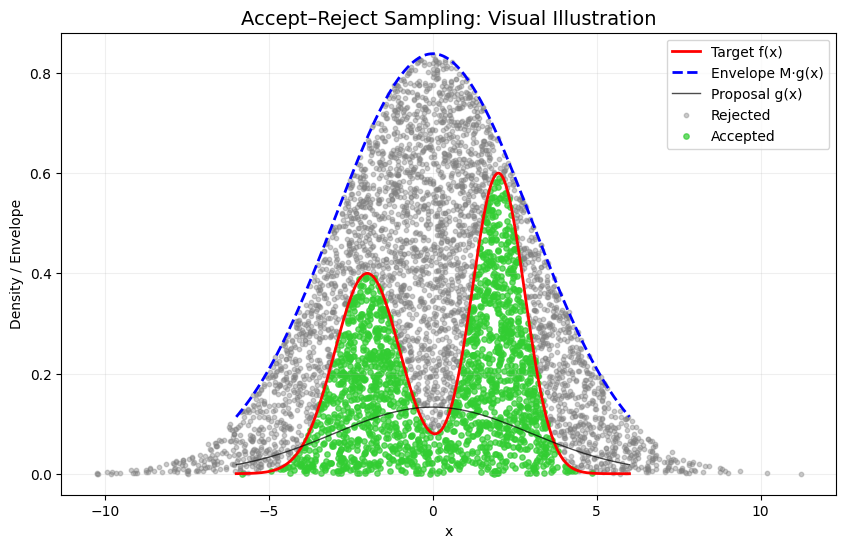

Number of accepted: 1736
Number of rejected: 3264


In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Target: Mixture of two Gaussians (unnormalized)
def f(x):
    return 0.6*np.exp(-0.5*((x-2)/0.8)**2) + 0.4*np.exp(-0.5*((x+2)/1.0)**2)

# Proposal: Normal(0, 3)
def g(x):
    return (1/np.sqrt(2*np.pi*3**2))*np.exp(-x**2/(2*3**2))

# Sampling from proposal
def g_sample(n):
    return np.random.normal(0, 3, n)

# Find scaling constant M
x_grid = np.linspace(-6, 6, 1000)
M = np.max(f(x_grid) / g(x_grid)) * 1.1  # small buffer
print(f"M = {M:.2f}")

# Accept–Reject Sampling
N = 5000
x_samples = g_sample(N)
u = np.random.rand(N)
accepted = []
rejected = []
for i in range(N):
    if u[i] < f(x_samples[i]) / (M * g(x_samples[i])):
        accepted.append((x_samples[i], u[i]))
    else:
        rejected.append((x_samples[i], u[i]))
accepted = np.array(accepted)
rejected = np.array(rejected)

# Plot target, proposal, and points
plt.figure(figsize=(10,6))
plt.plot(x_grid, f(x_grid), 'r-', lw=2, label='Target f(x)')
plt.plot(x_grid, M*g(x_grid), 'b--', lw=2, label='Envelope M·g(x)')
plt.plot(x_grid, g(x_grid), 'k-', lw=1, alpha=0.7, label='Proposal g(x)')

# Plot accepted and rejected points
plt.scatter(rejected[:,0], rejected[:,1]*M*g(rejected[:,0]), s=10, c='grey', alpha=0.4, label='Rejected')
plt.scatter(accepted[:,0], accepted[:,1]*M*g(accepted[:,0]), s=15, c='limegreen', alpha=0.7, label='Accepted')

plt.title("Accept–Reject Sampling: Visual Illustration", fontsize=14)
plt.xlabel("x")
plt.ylabel("Density / Envelope")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

print('Number of accepted:', len(accepted))
print('Number of rejected:', len(rejected))

M = 8.00


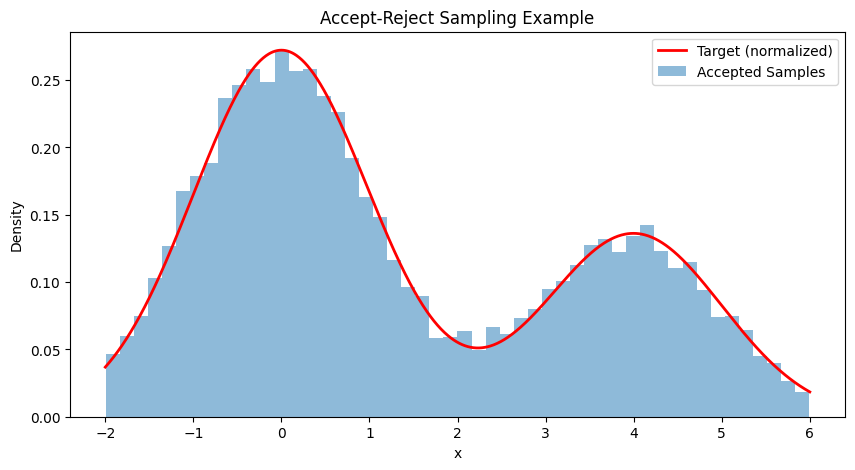

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Target density (unnormalized)
def f(x):
    return np.exp(-x**2 / 2) + 0.5 * np.exp(-(x - 4)**2 / 2)

# Proposal distribution g(x): Uniform(-2, 6)
def g_sample(n=1):
    return np.random.uniform(-2, 6, n)

def g_pdf(x):
    return np.where((x >= -2) & (x <= 6), 1/8, 0)

# Find M so that f(x) <= M * g(x)
x_grid = np.linspace(-2, 6, 1000)
M = np.max(f(x_grid) / g_pdf(x_grid))
print(f"M = {M:.2f}")

# Accept-Reject Sampling
N = 10000
samples = []
while len(samples) < N:
    x = g_sample(1)
    u = np.random.rand()
    if u < f(x) / (M * g_pdf(x)):
        samples.append(x[0])
samples = np.array(samples)

# Plot
plt.figure(figsize=(10,5))
plt.plot(x_grid, f(x_grid)/np.trapz(f(x_grid), x_grid), 'r-', lw=2, label='Target (normalized)')
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Accepted Samples')
plt.title("Accept-Reject Sampling Example")
plt.xlabel("x"); plt.ylabel("Density")
plt.legend()
plt.show()


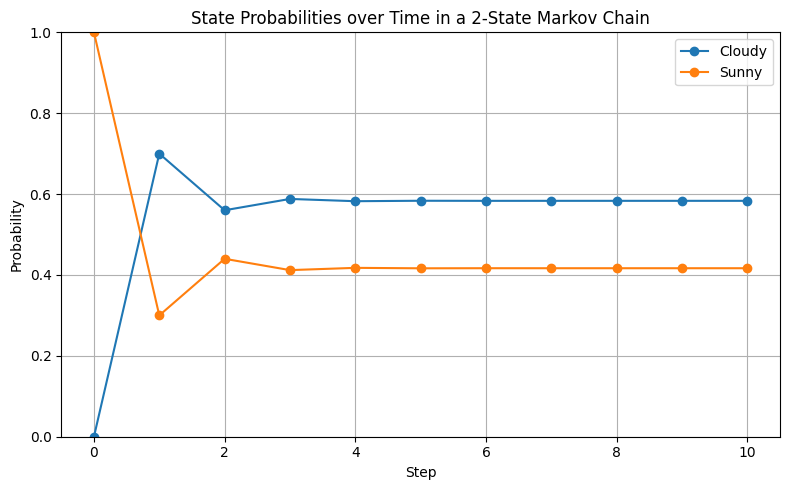

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Markov chain setup ----
# States order: [Sunny, Cloudy]
P = np.array([
    [0.3, 0.7],   # from Sunny -> [Sunny, Cloudy]
    [0.5, 0.5],   # from Cloudy -> [Sunny, Cloudy]
])

# Initial distribution (100% Sunny). Change if you want, e.g. [0.6, 0.4]
pi0 = np.array([1.0, 0.0])

# ---- Evolve probabilities ----
steps = 10  # number of transitions to show
probs = [pi0]
pi = pi0.copy()
for _ in range(steps):
    pi = pi @ P
    probs.append(pi)

probs = np.array(probs)   # shape: (steps+1, 2)

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(probs[:, 1], marker='o', label='Cloudy')
plt.plot(probs[:, 0], marker='o', label='Sunny')
plt.title('State Probabilities over Time in a 2-State Markov Chain')
plt.xlabel('Step')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# MCMC

We want to estimate the **posterior distribution of the mean** \( \mu \) given samples \( y_i \sim \mathcal{N}(\mu, 1) \).

The **log posterior** (up to a constant) is:

$$
\log p(\mu \mid y)
\propto
-\tfrac{1}{2}\sum_i (y_i - \mu)^2
-\tfrac{1}{2}\left(\frac{\mu}{10}\right)^2
$$

- First term → log-likelihood  
- Second term → Gaussian prior $$ \mu \sim \mathcal{N}(0, 10^2) $$

---

### 🔁 Metropolis Algorithm Steps

1. **Propose a new value**
   $$
   \mu' = \mu_t + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5^2)
   $$

2. **Compute the acceptance ratio**
   $$
   r = \exp\!\big[\log p(\mu') - \log p(\mu_t)\big]
   $$

3. **Accept or reject**
   - Accept with probability $ \min(1, r) $
   - Otherwise, keep the previous value $ \mu_t $

---



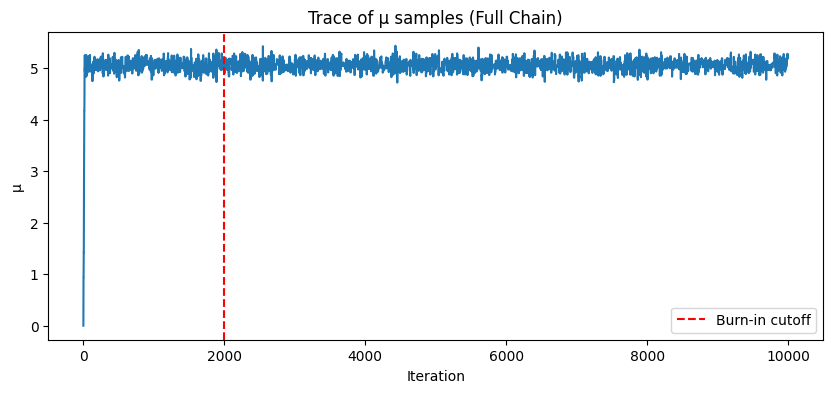

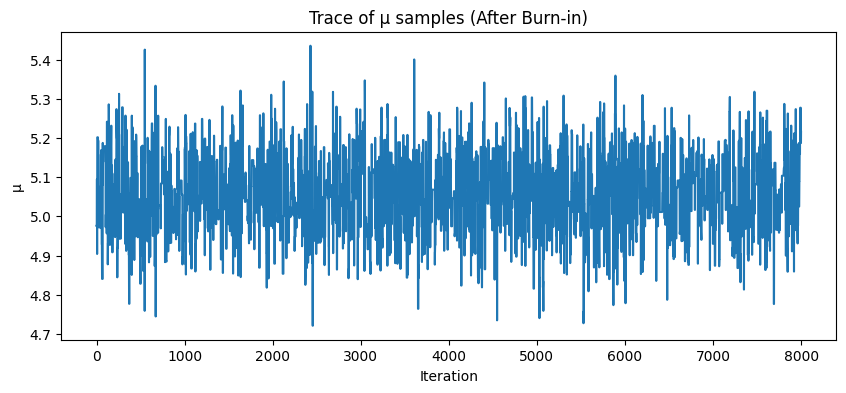

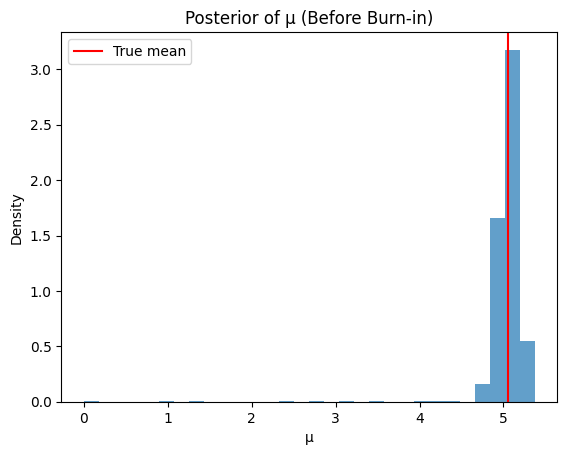

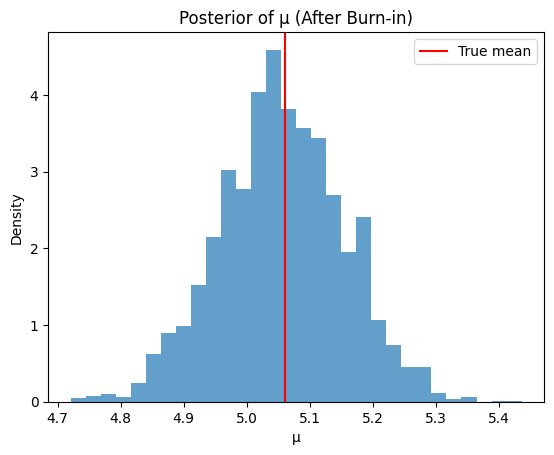

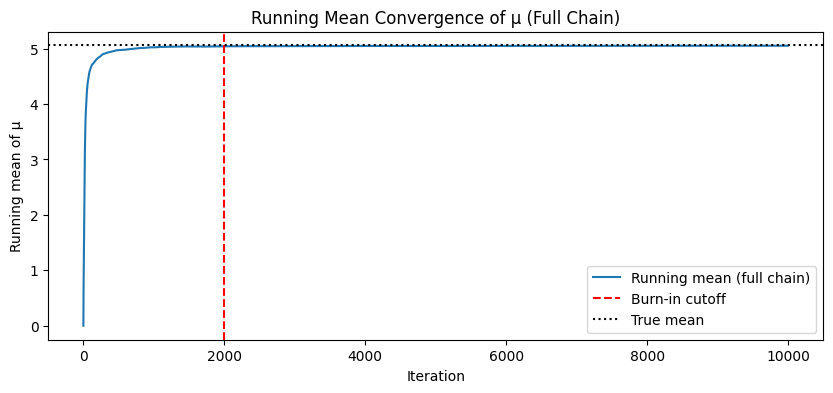

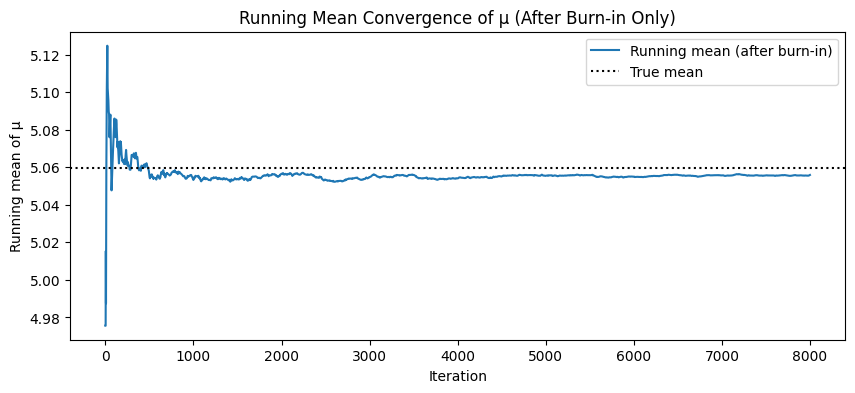

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# generate data
np.random.seed(0)
y = np.random.normal(5, 1, 100)

# log posterior (up to constant)
def log_posterior(mu):
    ll = -0.5 * np.sum((y - mu)**2)      # log-likelihood
    prior = -0.5 * (mu/10)**2            # log-prior
    return ll + prior

# MCMC sampler
N = 10000
chain = np.zeros(N)
mu_current = 0

for i in range(1, N):
    proposal = mu_current + np.random.normal(0, 0.5)
    accept_ratio = np.exp(log_posterior(proposal) - log_posterior(mu_current))
    if np.random.rand() < accept_ratio:
        mu_current = proposal
    chain[i] = mu_current

# burn-in
burn_in = 2000
chain_burned = chain[burn_in:]
chain_preburn = chain[:burn_in]

# running mean
running_mean = np.cumsum(chain) / np.arange(1, N + 1)
running_mean_post = np.cumsum(chain_burned) / np.arange(1, len(chain_burned) + 1)

# trace full with burn-in
plt.figure(figsize=(10, 4))
plt.plot(chain)
plt.axvline(burn_in, color='r', linestyle='--', label='Burn-in cutoff')
plt.title("Trace of μ samples (Full Chain)")
plt.xlabel("Iteration")
plt.ylabel("μ")
plt.legend()
plt.show()

# trace after burn-in
plt.figure(figsize=(10, 4))
plt.plot(chain_burned)
plt.title("Trace of μ samples (After Burn-in)")
plt.xlabel("Iteration")
plt.ylabel("μ")
plt.show()

# hist before burn-in
plt.figure()
plt.hist(chain_preburn, bins=30, density=True, alpha=0.7)
plt.axvline(np.mean(y), color='r', label='True mean')
plt.legend()
plt.title("Posterior of μ (Before Burn-in)")
plt.xlabel("μ")
plt.ylabel("Density")
plt.show()

# hist after burn-in
plt.figure()
plt.hist(chain_burned, bins=30, density=True, alpha=0.7)
plt.axvline(np.mean(y), color='r', label='True mean')
plt.legend()
plt.title("Posterior of μ (After Burn-in)")
plt.xlabel("μ")
plt.ylabel("Density")
plt.show()

# running mean full chain
plt.figure(figsize=(10, 4))
plt.plot(running_mean, label='Running mean (full chain)')
plt.axvline(burn_in, color='r', linestyle='--', label='Burn-in cutoff')
plt.axhline(np.mean(y), color='k', linestyle=':', label='True mean')
plt.title("Running Mean Convergence of μ (Full Chain)")
plt.xlabel("Iteration")
plt.ylabel("Running mean of μ")
plt.legend()
plt.show()

# running mean after burn-in
plt.figure(figsize=(10, 4))
plt.plot(running_mean_post, label='Running mean (after burn-in)')
plt.axhline(np.mean(y), color='k', linestyle=':', label='True mean')
plt.title("Running Mean Convergence of μ (After Burn-in Only)")
plt.xlabel("Iteration")
plt.ylabel("Running mean of μ")
plt.legend()
plt.show()



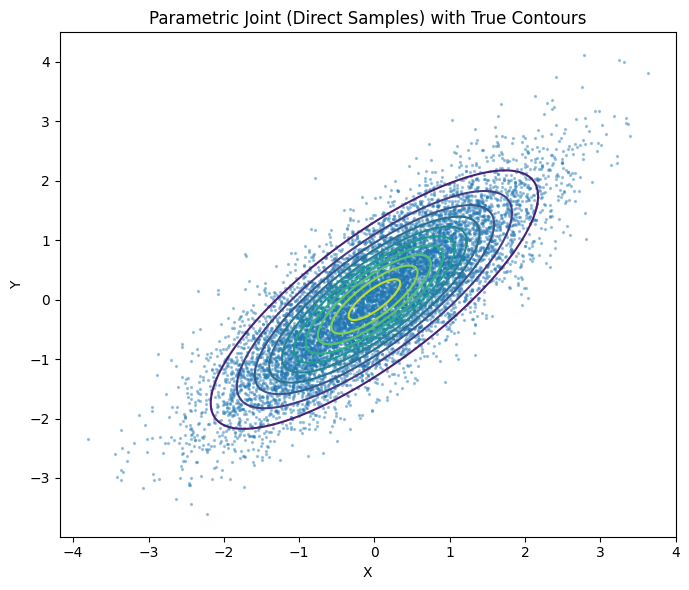

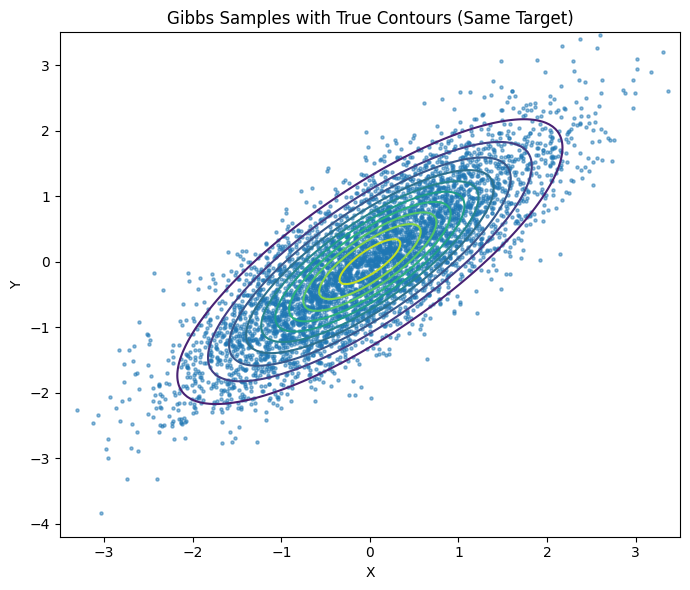

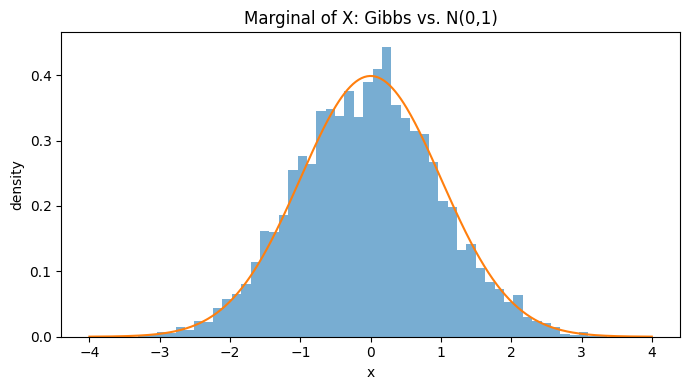

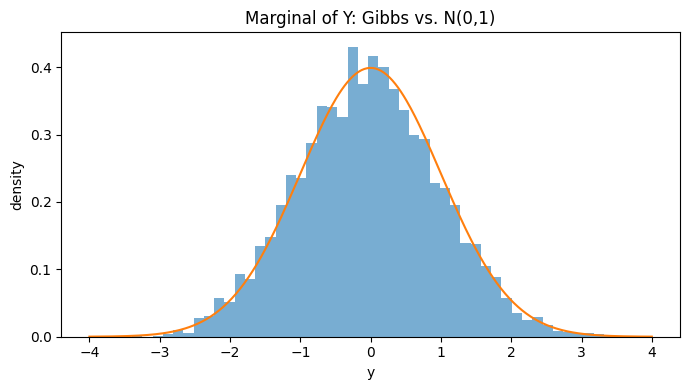

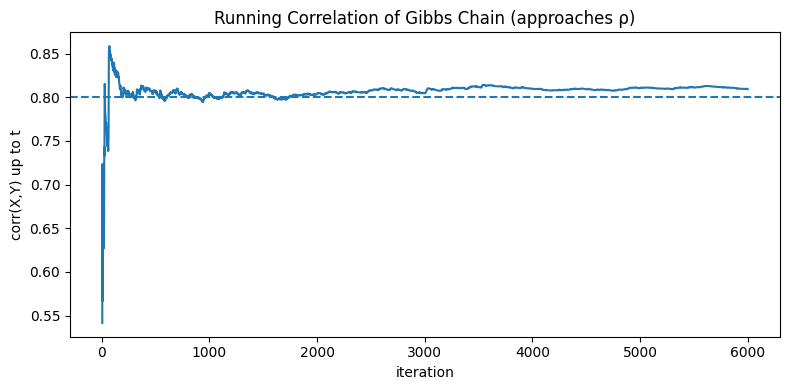

==== Summary Stats ====
Gibbs:  mean(X)=-0.037, var(X)=1.006, mean(Y)=-0.036, var(Y)=1.010, corr=0.810
Direct: mean(X)=-0.006, var(X)=1.017, mean(Y)=-0.001, var(Y)=1.021, corr=0.806
Target correlation (rho) = 0.800


In [23]:
# Gibbs vs. Parametric Joint — COMPLETE, RUNNABLE
# - Plots true (parametric) joint with contours
# - Plots Gibbs-sampled joint on same contours
# - Compares marginals to N(0,1)
# - Prints summary stats
# - Adds running correlation plot to show convergence

import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt

np.random.seed(42)

# -------- Target: Bivariate Normal with correlation rho --------
rho = 0.8
mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, rho],
                  [rho, 1.0]])

# -------- Utility: Bivariate Normal PDF on a grid --------
def bivnorm_pdf(X, Y, mu, Sigma):
    det = np.linalg.det(Sigma)
    inv = np.linalg.inv(Sigma)
    dx = X - mu[0]
    dy = Y - mu[1]
    Q = inv[0,0]*dx*dx + (inv[0,1]+inv[1,0])*dx*dy + inv[1,1]*dy*dy
    Z = (1.0 / (2.0 * pi * sqrt(det))) * np.exp(-0.5 * Q)
    return Z

# -------- Direct (parametric) samples from the true joint --------
n_true = 10000
true_samples = np.random.multivariate_normal(mu, Sigma, size=n_true)
x_true = true_samples[:, 0]
y_true = true_samples[:, 1]

# -------- Gibbs sampling for the same joint --------
def gibbs_bivariate_normal(rho, n_samples=6000, burn_in=1000, x0=0.0, y0=0.0):
    x = np.zeros(n_samples)
    y = np.zeros(n_samples)
    x[0], y[0] = x0, y0
    cond_sd = sqrt(1.0 - rho**2)  # variance same for both conditionals
    for i in range(1, n_samples):
        # x | y ~ N(rho*y, 1-rho^2)
        x[i] = np.random.normal(rho * y[i-1], cond_sd)
        # y | x ~ N(rho*x, 1-rho^2)
        y[i] = np.random.normal(rho * x[i], cond_sd)
    return x[burn_in:], y[burn_in:], x, y  # return full chain for diagnostics too

x_gibbs, y_gibbs, x_full, y_full = gibbs_bivariate_normal(rho=rho)

# -------- Contour grid (for both plots) --------
grid_lim = 3.5
grid_n = 200
xs = np.linspace(-grid_lim, grid_lim, grid_n)
ys = np.linspace(-grid_lim, grid_lim, grid_n)
XX, YY = np.meshgrid(xs, ys)
ZZ = bivnorm_pdf(XX, YY, mu, Sigma)

# -------- Figure A: Parametric joint + true contours --------
plt.figure(figsize=(7, 6))
plt.contour(XX, YY, ZZ, levels=10)
plt.scatter(x_true, y_true, s=2, alpha=0.35)
plt.title("Parametric Joint (Direct Samples) with True Contours")
plt.xlabel("X"); plt.ylabel("Y")
plt.tight_layout()
plt.show()

# -------- Figure B: Gibbs joint + same contours --------
plt.figure(figsize=(7, 6))
plt.contour(XX, YY, ZZ, levels=10)
plt.scatter(x_gibbs, y_gibbs, s=5, alpha=0.5)
plt.title("Gibbs Samples with True Contours (Same Target)")
plt.xlabel("X"); plt.ylabel("Y")
plt.tight_layout()
plt.show()

# -------- Figure C: Marginal comparisons vs N(0,1) --------
u = np.linspace(-4, 4, 400)
phi = (1/np.sqrt(2*pi)) * np.exp(-0.5 * u**2)

plt.figure(figsize=(7, 4))
plt.hist(x_gibbs, bins=50, density=True, alpha=0.6)
plt.plot(u, phi)
plt.title("Marginal of X: Gibbs vs. N(0,1)")
plt.xlabel("x"); plt.ylabel("density")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.hist(y_gibbs, bins=50, density=True, alpha=0.6)
plt.plot(u, phi)
plt.title("Marginal of Y: Gibbs vs. N(0,1)")
plt.xlabel("y"); plt.ylabel("density")
plt.tight_layout()
plt.show()

# -------- Figure D: Running correlation to visualize convergence --------
def running_corr(x, y):
    out = np.empty_like(x, dtype=float)
    for t in range(len(x)):
        if t < 5:
            out[t] = np.nan
        else:
            out[t] = np.corrcoef(x[:t+1], y[:t+1])[0,1]
    return out

corr_path = running_corr(x_full, y_full)
plt.figure(figsize=(8, 4))
plt.plot(corr_path)
plt.axhline(rho, linestyle="--")
plt.title("Running Correlation of Gibbs Chain (approaches ρ)")
plt.xlabel("iteration"); plt.ylabel("corr(X,Y) up to t")
plt.tight_layout()
plt.show()

# -------- Numerical sanity checks --------
def stats(arr):
    return float(np.mean(arr)), float(np.var(arr))

mx, vx = stats(x_gibbs)
my, vy = stats(y_gibbs)
corr_gibbs = float(np.corrcoef(x_gibbs, y_gibbs)[0,1])
corr_true = float(np.corrcoef(x_true, y_true)[0,1])

print("==== Summary Stats ====")
print(f"Gibbs:  mean(X)={mx:.3f}, var(X)={vx:.3f}, mean(Y)={my:.3f}, var(Y)={vy:.3f}, corr={corr_gibbs:.3f}")
print(f"Direct: mean(X)={np.mean(x_true):.3f}, var(X)={np.var(x_true):.3f}, mean(Y)={np.mean(y_true):.3f}, var(Y)={np.var(y_true):.3f}, corr={corr_true:.3f}")
print(f"Target correlation (rho) = {rho:.3f}")


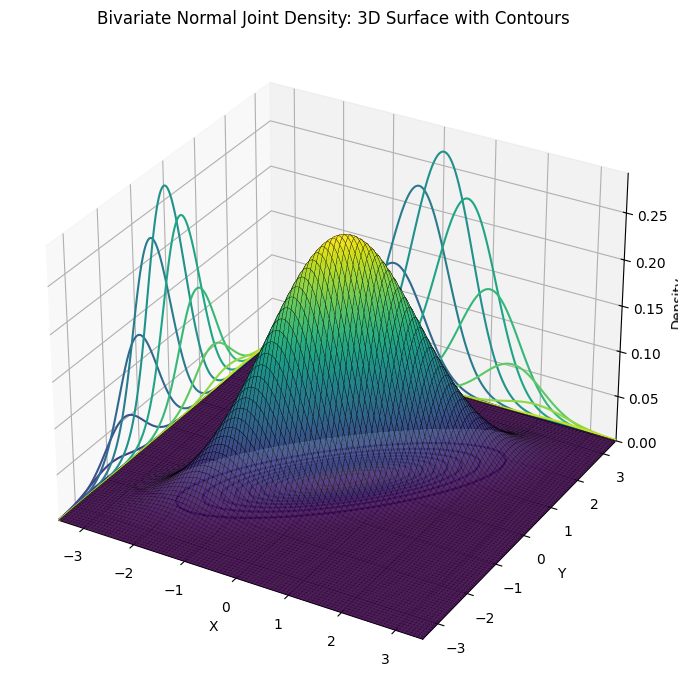

In [26]:
# --- 3D surface + contour projections for the joint PDF ---
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface
surf = ax.plot_surface(XX, YY, ZZ, rstride=2, cstride=2,
                       linewidth=0.2, edgecolor='k',
                       alpha=0.9, cmap='viridis', antialiased=True)

# Contour projections (same contours you saw in 2D), onto:
# - the bottom (z=0) plane,
# - the x=min plane,
# - the y=max plane.
levels = 12
ax.contour(XX, YY, ZZ, levels=levels, zdir='z', offset=0.0, cmap='viridis')              # onto z=0
ax.contour(XX, YY, ZZ, levels=levels, zdir='x', offset=-grid_lim, cmap='viridis')        # onto x=-grid_lim
ax.contour(XX, YY, ZZ, levels=levels, zdir='y', offset= grid_lim, cmap='viridis')        # onto y=+grid_lim

# Axes limits to frame the projections
ax.set_xlim(-grid_lim, grid_lim)
ax.set_ylim(-grid_lim, grid_lim)
ax.set_zlim(0.0, ZZ.max()*1.1)

ax.set_title("Bivariate Normal Joint Density: 3D Surface with Contours")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Density")
plt.tight_layout()
plt.show()


# MCMC
### 🔍 Context

We are estimating the AR(1) model:

$$
y_t = \phi y_{t-1} + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, 1)
$$

Given observed data $ y = (y_1, y_2, \dots, y_T) $, we want the posterior distribution of $ \phi $:

$$
p(\phi \mid y) \propto p(y \mid \phi) \, p(\phi)
$$

Taking the logarithm gives:

$$
\log p(\phi \mid y) = \log p(y \mid \phi) + \log p(\phi) + \text{constant}
$$

---

### 🧮 Likelihood Term

Because the residuals $\varepsilon_t = y_t - \phi y_{t-1}$) are independent $\mathcal{N}(0,1)$ draws,

the log-likelihood (up to a constant) is:

$$
\log p(y \mid \phi) \propto -\frac{1}{2}\sum_{t=2}^{T}(y_t - \phi y_{t-1})^2
$$

- This term penalizes values of $\phi$ that make the residuals large.  
- The smaller the residuals, the higher the likelihood.

---

### 🧠 Prior Term

We assume a Gaussian prior:

$$
\phi \sim \mathcal{N}(0, 1^2)
$$

So its log-density (up to a constant) is:

$$
\log p(\phi) \propto -\frac{1}{2}\left(\frac{\phi}{1}\right)^2
$$

- This prior gently pulls $\phi$ toward zero (regularization).  
- The variance of 1 controls the strength of that pull.

---

### ⚙️ Combined Log Posterior

Combining the likelihood and prior gives:

$$
\log p(\phi \mid y)
\propto
-\frac{1}{2}\sum_{t=2}^{T}(y_t - \phi y_{t-1})^2
-\frac{1}{2}\left(\frac{\phi}{1}\right)^2
$$

- **First term:** log-likelihood (model fit)  
- **Second term:** log-prior (regularization)  
- “Up to a constant” means ignoring terms that don’t depend on \( \phi \).

---

### 💡 Intuitive Takeaway

This expression balances two forces:

- **Fit:** Choose $ \phi $ that makes $ y_t \approx \phi y_{t-1} $ (small residuals).  
- **Regularization:** Keep $ \phi $ near zero, as favored by the prior.  

The MCMC algorithm explores this posterior surface — the regions of $ \phi $ that best explain the data while remaining consistent with the prior.


### Explanation

We are estimating the **posterior distribution of the AR(1) coefficient** $\phi$ in the model:

$$
y_t = \phi y_{t-1} + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

#### Log posterior (up to a constant):

$$
\log p(\phi \mid y)
\propto
-\tfrac{1}{2}\sum_{t=2}^T (y_t - \phi y_{t-1})^2
-\tfrac{1}{2}\left(\frac{\phi}{1}\right)^2
$$

- First term → log-likelihood from the AR(1) model  
- Second term → prior $$\phi \sim \mathcal{N}(0, 1)$$  
- The constraint  $|\phi| < 1 $ enforces **stationarity**

---

### 🔁 Metropolis Algorithm Steps

1. **Propose a new value**
   $$
   \phi' = \phi_t + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.05^2)
   $$

2. **Compute the acceptance ratio**
   $$
   r = \exp\!\big[\log p(\phi') - \log p(\phi_t)\big]
   $$

3. **Accept or reject**
   - Accept with probability $ \min(1, r) $
   - Otherwise, keep $ \phi_t $



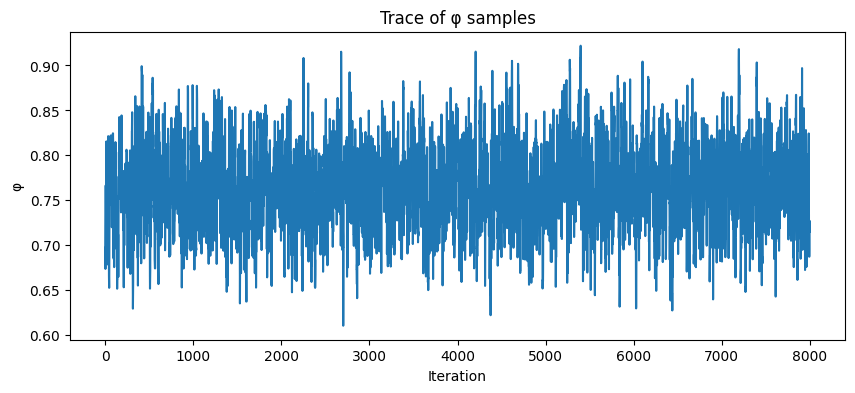

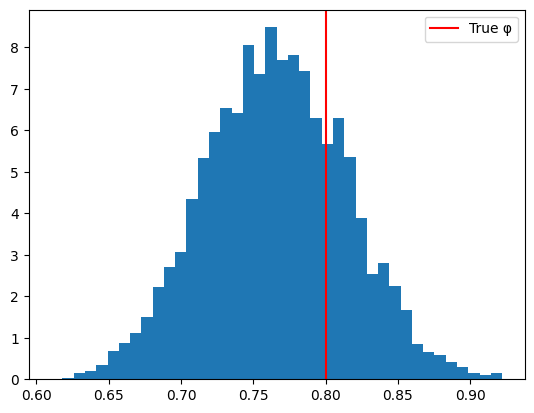

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate AR(1) data
np.random.seed(42)
T = 200
phi_true, sigma_true = 0.8, 1.0
y = np.zeros(T)
for t in range(1, T):
    y[t] = phi_true * y[t-1] + np.random.normal(0, sigma_true)

# Log posterior (up to constant)
def log_posterior(phi):
    if abs(phi) > 1:
        return -np.inf
    residuals = y[1:] - phi * y[:-1]
    ll = -0.5 * np.sum(residuals**2)
    prior = -0.5 * (phi / 1.0)**2
    return ll + prior

# MCMC sampler
N = 10000
chain = np.zeros(N)
phi_current = 0.0
for i in range(1, N):
    proposal = phi_current + np.random.normal(0, 0.05)
    accept_ratio = np.exp(log_posterior(proposal) - log_posterior(phi_current))
    if np.random.rand() < accept_ratio:
        phi_current = proposal
    chain[i] = phi_current

burned = chain[2000:]
plt.figure(figsize=(10,4))
plt.plot(burned)
plt.title("Trace of φ samples")
plt.xlabel("Iteration"); plt.ylabel("φ")
plt.show()

plt.hist(burned, bins=40, density=True)
plt.axvline(phi_true, color='r', label='True φ')
plt.legend(); plt.show()


# BSTS

2025-10-18 16:00:22 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

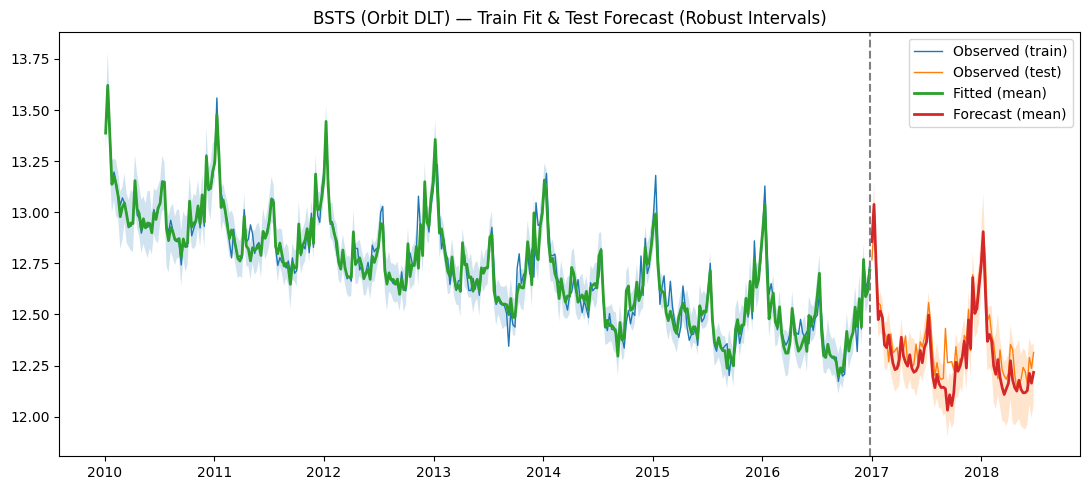

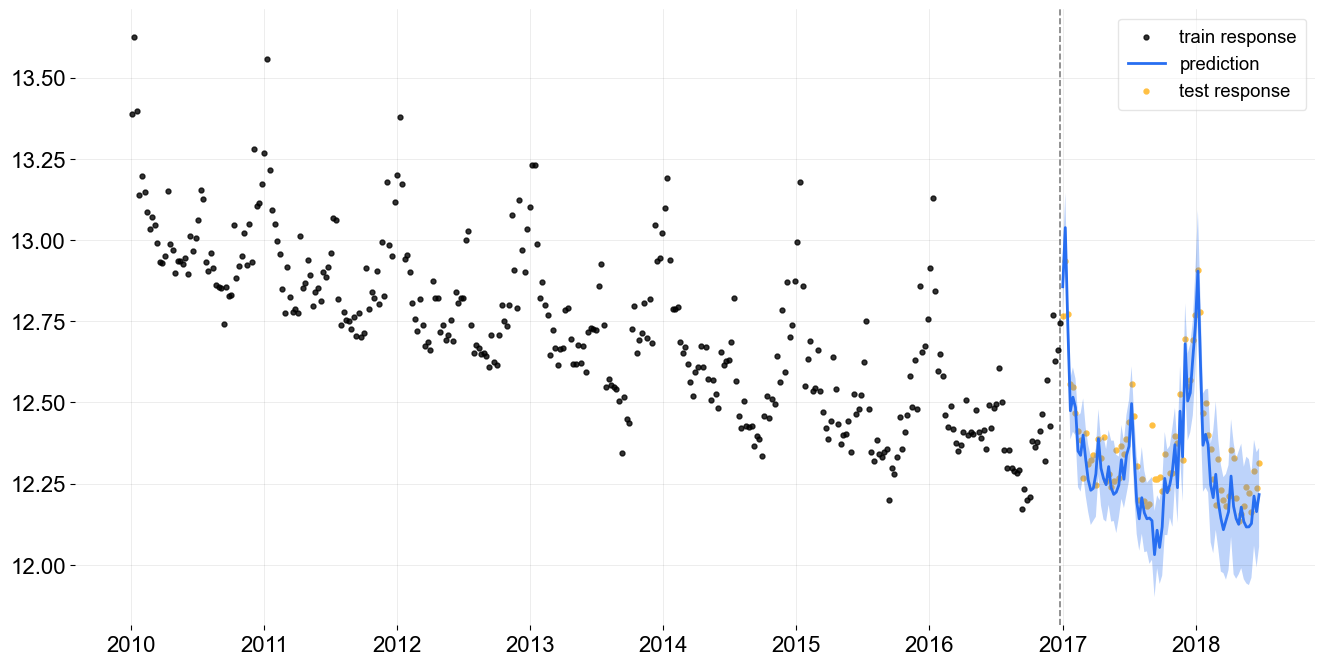

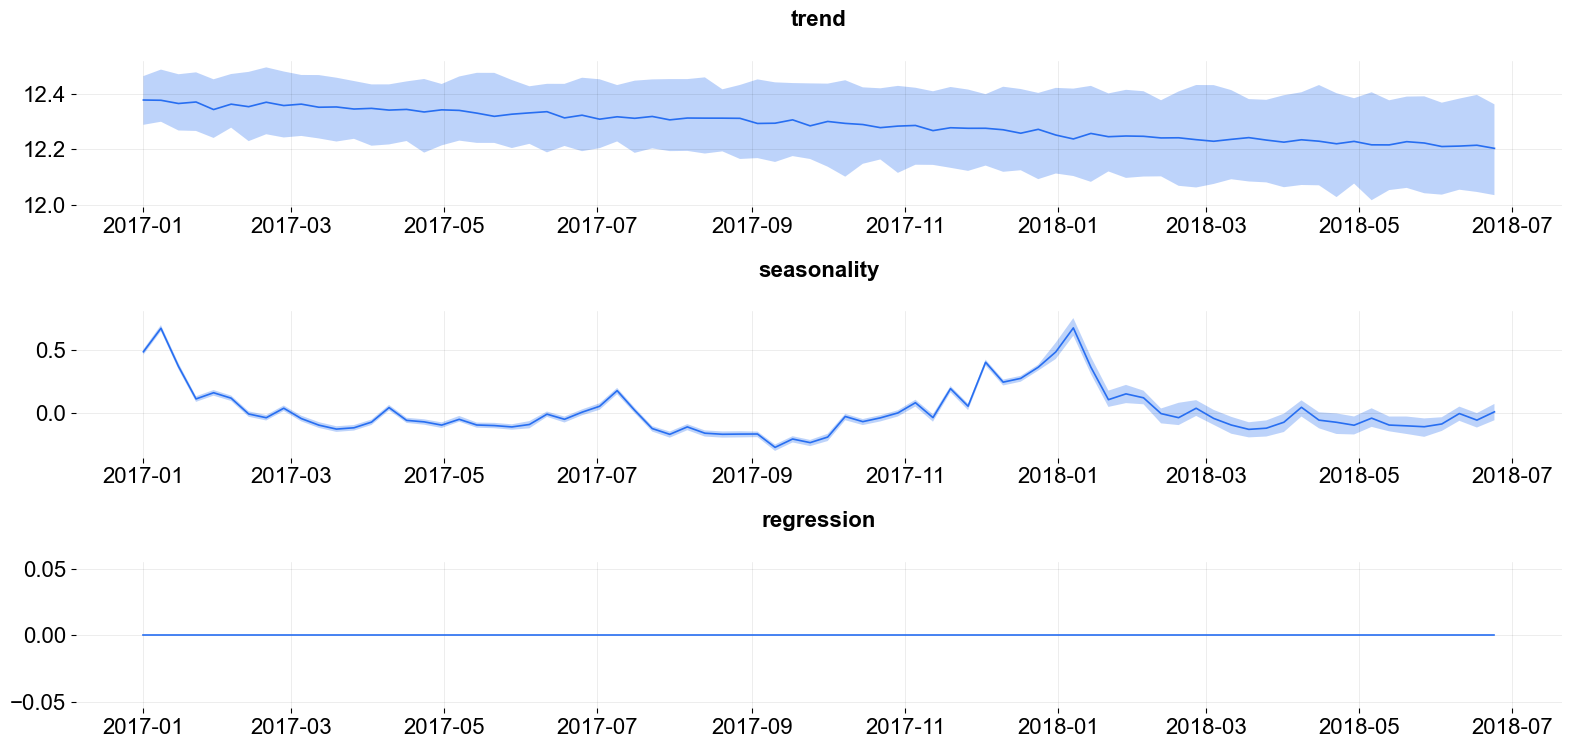

<Figure size 640x480 with 0 Axes>


Accuracy (MAPE is optional):
Train RMSE: 0.06095573644457301
Test  RMSE: 0.08977708281386294
Train  MAE: 0.040905469628523095
Test   MAE: 0.07202331364972618


In [23]:
# pip install orbit-ml matplotlib pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

# -----------------
# 1) Load & split
# -----------------
df = load_iclaims()
df['week_start_date'] = pd.to_datetime(df['week'])

cutoff = pd.Timestamp('2017-01-01')
train = df[df['week_start_date'] < cutoff].copy()
test  = df[df['week_start_date'] >= cutoff].copy()

# -----------------
# 2) Model (DLT / BSTS)
# -----------------
USE_MCMC =  True # set True for full Bayesian sampling via Stan (slower)
model = DLT(
    date_col='week_start_date',
    response_col='claims',
    seasonality=52,
    level_sm_input=0.1,
    slope_sm_input=0.1,
    seed=123,
    estimator='stan-mcmc' if USE_MCMC else 'stan-map',
)

model.fit(train)

# 3) Quick numeric summaries ----------
def rmse(y, yhat): return float(np.sqrt(np.mean((y - yhat)**2)))
def mae(y, yhat):  return float(np.mean(np.abs(y - yhat)))

# -----------------
# 4) Predict with posterior arrays
# -----------------
pred_train = model.predict(train, decompose=True, store_prediction_array=True)
pred_test  = model.predict(test,  decompose=True, store_prediction_array=True)

def add_intervals(df_pred, lower=0.05, upper=0.95):
    """
    Make df_pred['pred_lo'] and df_pred['pred_hi'] robustly.
    Prefer 'prediction_array'; fall back to common column names if needed.
    """
    # Case A: posterior samples are present
    if 'prediction_array' in df_pred.columns:
        # prediction_array is a column of arrays; stack to (n, S)
        A = np.vstack(df_pred['prediction_array'].to_numpy())
        df_pred['pred_lo'] = np.quantile(A, lower, axis=1)
        df_pred['pred_hi'] = np.quantile(A, upper, axis=1)
        return df_pred

    # Case B: different Orbit versions expose various names
    candidates = [
        ('prediction_5', 'prediction_95'),
        ('prediction_10', 'prediction_90'),
        ('prediction_lb', 'prediction_ub'),
        ('yhat_lb', 'yhat_ub'),
    ]
    for lo, hi in candidates:
        if lo in df_pred.columns and hi in df_pred.columns:
            df_pred['pred_lo'] = df_pred[lo].values
            df_pred['pred_hi'] = df_pred[hi].values
            return df_pred

    # Case C: no intervals available → build a narrow band around point preds
    pad = 0.05 * np.nanmedian(np.abs(df_pred['prediction'].values))
    df_pred['pred_lo'] = df_pred['prediction'] - pad
    df_pred['pred_hi'] = df_pred['prediction'] + pad
    return df_pred

pred_train = add_intervals(pred_train, 0.05, 0.95)
pred_test  = add_intervals(pred_test,  0.05, 0.95)

# -----------------
# 4) Plots
# -----------------

# 4a) Fit & forecast overview
fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(train['week_start_date'], train['claims'], lw=1, label='Observed (train)')
ax.plot(test['week_start_date'],  test['claims'],  lw=1, label='Observed (test)')

ax.plot(pred_train['week_start_date'], pred_train['prediction'], lw=2, label='Fitted (mean)')
ax.fill_between(pred_train['week_start_date'], pred_train['pred_lo'], pred_train['pred_hi'], alpha=0.2)

ax.plot(pred_test['week_start_date'], pred_test['prediction'], lw=2, label='Forecast (mean)')
ax.fill_between(pred_test['week_start_date'], pred_test['pred_lo'], pred_test['pred_hi'], alpha=0.2)

ax.axvline(train['week_start_date'].iloc[-1], ls='--', color='gray')
ax.set_title("BSTS (Orbit DLT) — Train Fit & Test Forecast (Robust Intervals)")
ax.legend()
plt.tight_layout(); plt.show()

# 4b) Pretty helper plots from Orbit (still work)
plot_predicted_data(
    training_actual_df=train[['week_start_date', 'claims']],
    predicted_df=pred_test,
    date_col='week_start_date',
    actual_col='claims',
    test_actual_df=test[['week_start_date', 'claims']],
)


plot_predicted_components(predicted_df=pred_test, date_col='week_start_date')
plt.suptitle("Decomposition: Level/Slope · Seasonality · (if any) Regressors", y=1.02)
plt.tight_layout(); plt.show()

print("\nAccuracy (MAPE is optional):")
print("Train RMSE:", rmse(train['claims'].values, pred_train['prediction'].values))
print("Test  RMSE:", rmse(test['claims'].values,  pred_test['prediction'].values))
print("Train  MAE:", mae(train['claims'].values,  pred_train['prediction'].values))
print("Test   MAE:", mae(test['claims'].values,   pred_test['prediction'].values))

2025-10-18 15:51:44 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


All columns: ['week', 'claims', 'trend.unemploy', 'trend.filling', 'trend.job', 'sp500', 'vix', 'week_start_date']
Detected regressors: ['trend.unemploy', 'trend.filling', 'trend.job']


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Component columns detected: ['seasonality', 'regression']
Regression component all zeros? -> False


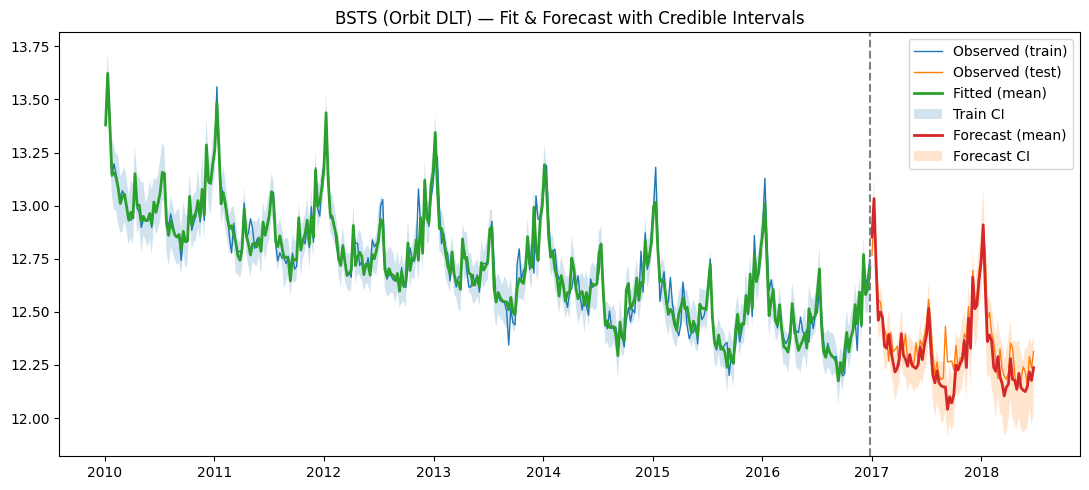

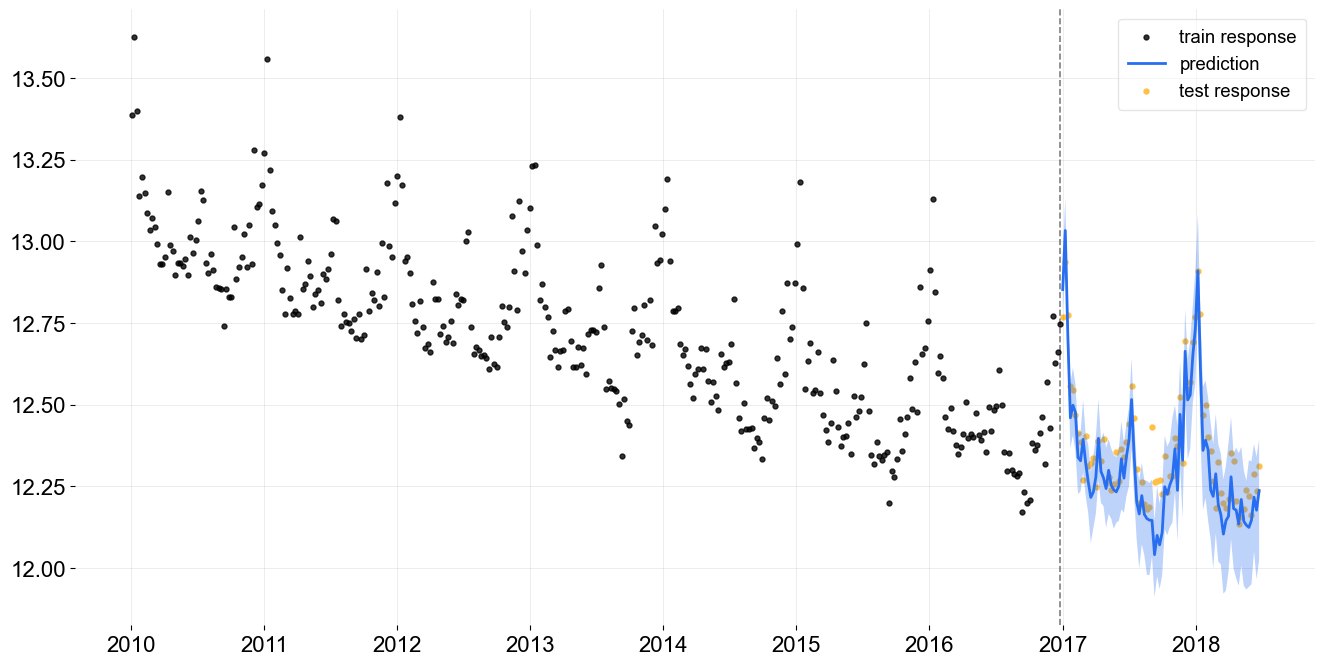

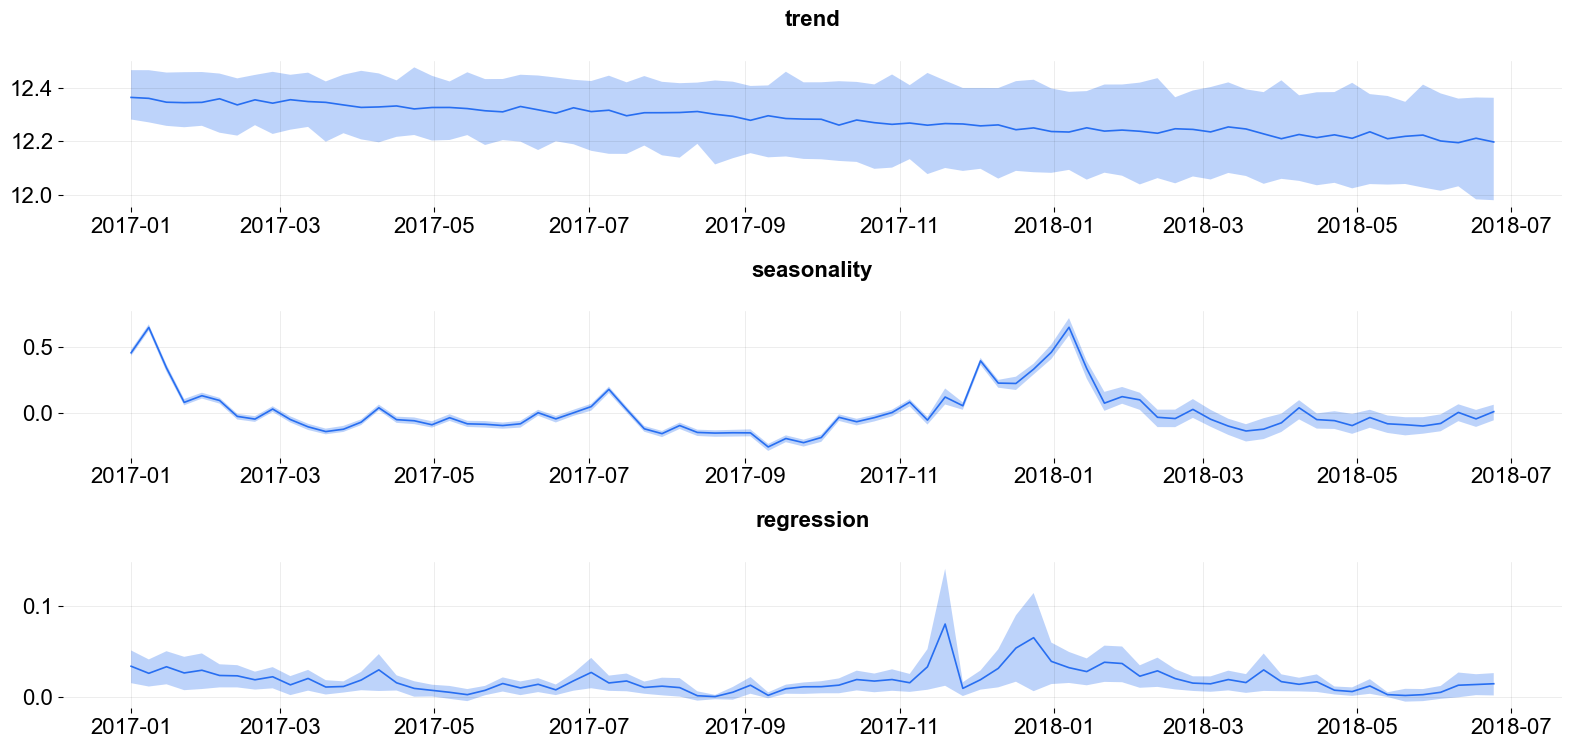

<Figure size 640x480 with 0 Axes>


Accuracy (MAPE is optional):
Train RMSE: 0.05977974143911677
Test  RMSE: 0.08731464853588693
Train  MAE: 0.04057909410891677
Test   MAE: 0.06922771302817761

Regression contribution (TEST) — median: 0.016, std: 0.014


In [20]:
# pip install orbit-ml pandas matplotlib numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_components

# ---------- 1) Load & verify regressors ----------
df = load_iclaims()
df['week_start_date'] = pd.to_datetime(df['week'])

candidate_names = ['trend.unemploy', 'trend.filling', 'trend.job']  # common in iClaims
available = [c for c in candidate_names if c in df.columns]

print("All columns:", df.columns.tolist())
print("Detected regressors:", available)

if not available:
    raise ValueError(
        "No iClaims regressors detected. Your load_iclaims() build may differ.\n"
        "Expected any of: 'trend.unemploy','trend.filling','trend.job'."
    )

# basic sanity: no NaN in regressors
if df[available].isna().any().any():
    raise ValueError("Regressor columns contain NaNs; please impute them before fitting.")

# ---------- 2) Split ----------
cutoff = pd.Timestamp('2017-01-01')
train = df[df['week_start_date'] < cutoff].copy()
test  = df[df['week_start_date'] >= cutoff].copy()

# ---------- 3) Build BSTS (DLT) with MCMC & wider regressor prior ----------
# Notes:
# - estimator='stan-mcmc' prevents MAP shrink-to-zero behavior
# - regressor_sigma_prior controls prior sd for betas (bigger → less shrinkage)
USE_MCMC = True

# after you build `available` (your regressor_col list)
n_reg = len(available)

model = DLT(
    date_col='week_start_date',
    response_col='claims',
    regressor_col=available,
    seasonality=52,
    level_sm_input=0.1,
    slope_sm_input=0.1,
    # >>> Priors must be lists/arrays of length n_reg, NOT scalars <<<
    regressor_sigma_prior=[1.5] * n_reg,   # widen to avoid shrink-to-zero
    # (optionally) set means for betas; zero-centered is typical:
    seed=123,
    estimator='stan-mcmc',
)


model.fit(train)

# ---------- 4) Predict with posterior arrays (for robust intervals) ----------
pred_train = model.predict(train, decompose=True, store_prediction_array=True)
pred_test  = model.predict(test,  decompose=True, store_prediction_array=True)

def add_intervals(df_pred, lower=0.05, upper=0.95):
    if 'prediction_array' in df_pred.columns:
        A = np.vstack(df_pred['prediction_array'].to_numpy())  # (n, S)
        df_pred['pred_lo'] = np.quantile(A, lower, axis=1)
        df_pred['pred_hi'] = np.quantile(A, upper, axis=1)
        return df_pred
    for lo, hi in [('prediction_5','prediction_95'),
                   ('prediction_10','prediction_90'),
                   ('prediction_lb','prediction_ub'),
                   ('yhat_lb','yhat_ub')]:
        if lo in df_pred.columns and hi in df_pred.columns:
            df_pred['pred_lo'] = df_pred[lo].values
            df_pred['pred_hi'] = df_pred[hi].values
            return df_pred
    pad = 0.05 * np.nanmedian(np.abs(df_pred['prediction'].values))
    df_pred['pred_lo'] = df_pred['prediction'] - pad
    df_pred['pred_hi'] = df_pred['prediction'] + pad
    return df_pred

pred_train = add_intervals(pred_train)
pred_test  = add_intervals(pred_test)

# ---------- 5) Sanity-check: did regression component show up & is it non-zero? ----------
comp_cols = [c for c in ['level','slope','seasonality','regression'] if c in pred_test.columns]
print("Component columns detected:", comp_cols)
if 'regression' not in comp_cols:
    raise RuntimeError("Orbit did not expose 'regression' component. Check your Orbit version.")

# Contribution should not be identically zero
is_flat_zero = np.allclose(pred_test['regression'].values, 0.0, atol=1e-9)
print("Regression component all zeros? ->", is_flat_zero)
if is_flat_zero:
    raise RuntimeError(
        "Regression component is flat 0. This usually means coefficients shrank to ~0.\n"
        "Try increasing regressor_sigma_prior further (e.g., 3.0) or verify regressor variance."
    )

# ---------- 6) Plots ----------
# Fit & forecast with credible intervals
fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(train['week_start_date'], train['claims'], lw=1, label='Observed (train)')
ax.plot(test['week_start_date'],  test['claims'],  lw=1, label='Observed (test)')
ax.plot(pred_train['week_start_date'], pred_train['prediction'], lw=2, label='Fitted (mean)')
ax.fill_between(pred_train['week_start_date'], pred_train['pred_lo'], pred_train['pred_hi'], alpha=0.2, label='Train CI')
ax.plot(pred_test['week_start_date'], pred_test['prediction'], lw=2, label='Forecast (mean)')
ax.fill_between(pred_test['week_start_date'], pred_test['pred_lo'], pred_test['pred_hi'], alpha=0.2, label='Forecast CI')
ax.axvline(train['week_start_date'].iloc[-1], ls='--', color='gray')
ax.set_title("BSTS (Orbit DLT) — Fit & Forecast with Credible Intervals")
ax.legend()
plt.tight_layout(); plt.show()

plot_predicted_data(
    training_actual_df=train[['week_start_date', 'claims']],
    predicted_df=pred_test,
    date_col='week_start_date',
    actual_col='claims',
    test_actual_df=test[['week_start_date', 'claims']],
)


# Component decomposition — you should see a non-flat "Regression" panel now
plot_predicted_components(predicted_df=pred_test, date_col='week_start_date')
plt.suptitle("Decomposition: Level · Slope · Seasonality · Regression", y=1.02)
plt.tight_layout(); plt.show()

# ---------- 7) Quick numeric summaries ----------
def rmse(y, yhat): return float(np.sqrt(np.mean((y - yhat)**2)))
def mae(y, yhat):  return float(np.mean(np.abs(y - yhat)))

print("\nAccuracy (MAPE is optional):")
print("Train RMSE:", rmse(train['claims'].values, pred_train['prediction'].values))
print("Test  RMSE:", rmse(test['claims'].values,  pred_test['prediction'].values))
print("Train  MAE:", mae(train['claims'].values,  pred_train['prediction'].values))
print("Test   MAE:", mae(test['claims'].values,   pred_test['prediction'].values))

# Aggregate contribution of regression on TEST (median)
reg_median = float(np.median(pred_test['regression'].values))
reg_std    = float(np.std(pred_test['regression'].values))
print(f"\nRegression contribution (TEST) — median: {reg_median:.3f}, std: {reg_std:.3f}")
